# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163355 sha256=72a193c965ca8f341549e65fa0292155346deaddc461666495778530b9f60a2d
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [ ]:
# Used to ignore the warning given as output of the code
import warnings
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np, pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt

# Slightly advanced library for data visualization
import seaborn as sns

# A dictionary output that does not raise a key error
from collections import defaultdict

# A performance metrics in sklearn
from sklearn.metrics import mean_squared_error

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/GreatLearning/Project 3_Amazon Products/ratings_Electronics.csv', names = ['user_id', 'prod_id', 'rating', 'timestamp'])

In [ ]:
df.shape

(7824482, 4)

In [ ]:
df.describe()

,rating,timestamp
count,7.824482e+06,7.824482e+06
mean,4.012337e+00,1.338178e+09
std,1.380910e+00,6.900426e+07
min,1.000000e+00,9.127296e+08
25%,3.000000e+00,1.315354e+09
50%,5.000000e+00,1.361059e+09
75%,5.000000e+00,1.386115e+09
max,5.000000e+00,1.406074e+09


In [ ]:
df.head()

,user_id,prod_id,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


###Reducing Size of Data

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

#Now df only has users who have given at least 50 ratings
df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF: #If the rating is less than the cutoff, then add it to the list of users to be excluded
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating,timestamp
1310,A3LDPF5FMB782Z,1400501466,5.0,1336003200
1322,A1A5KUIIIHFF4U,1400501466,1.0,1332547200
1335,A2XIOXRRYX0KZY,1400501466,3.0,1371686400
1451,AW3LX47IHPFRL,1400501466,5.0,1339804800
1456,A1E3OB6QMBKRYZ,1400501466,1.0,1350086400


Now we have a dataframe with users that has given more than 50 ratings, and with items that have received at least 5 ratings

## **Exploratory Data Analysis**

### **Shape of the data**

In [ ]:
#check the number of rows and columns after only removing the users who have given less than 50 ratings
df.shape

(125871, 4)

In [ ]:
# Check the number of rows and columns and provide observations
df_final.shape

(65290, 4)

Observations:

- The number of rows have drastically reduced from ~7.5 million to ~125 thousand rows after only removing the users who had given less than 50 ratings
- The number of rows then gets reduced to ~65 thousand after removing items that do not have more than 5 ratings.
- This means that only around **1.67%** of users on Amazon gave more than 50 ratings.


### **Data types**

In [ ]:
# Check Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65290 entries, 1310 to 7824427
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    65290 non-null  object 
 1   prod_id    65290 non-null  object 
 2   rating     65290 non-null  float64
 3   timestamp  65290 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 2.5+ MB


Observations:

- user and product IDs are object datatypes, rating data are floats, and timestamp are integers.
- There are also no null values found.

### **Checking for missing values**

In [ ]:
# Check for missing values present and provide observations
df_final.isnull().sum()

user_id      0
prod_id      0
rating       0
timestamp    0
dtype: int64

Observations:
- There are no null values found in the remaining data.

### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable and provide observations
df_final['rating'].describe()

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

Observations:
- In the remaining data, it can also be observed that the rating is very negatively skewed.
- The mean rating is 4.3
- At the 25th percentile of rating, the rating is still is still 4.

### **Checking the rating distribution**

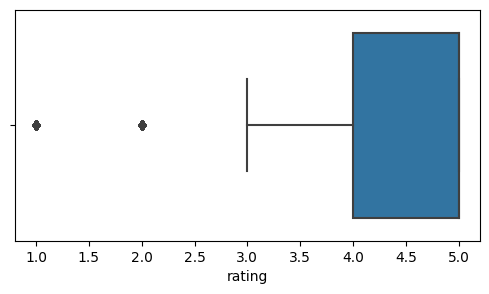

In [ ]:
plt.figure(figsize = (6,3))
sns.boxplot(data=df_final, x = 'rating');

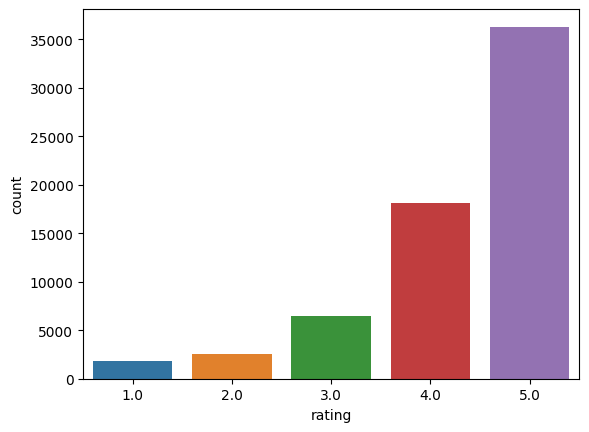

In [ ]:
sns.countplot(data=df_final, x = 'rating');

Observations:
- As can be seen in the plots, the data is very skewed to the left, with most of the ratings being 4 and 5.
- Very few people give ratings between 1 to 3, hinting that people tend not to give a rating when they do not like the products.

### **Checking the number of unique users and items in the dataset**

In [ ]:
#Number of unique users in the dataset
df_final['user_id'].nunique()

1540

In [ ]:
#Number of unique items in the dataset
df_final['prod_id'].nunique()

5689

Write your observations here:
- There are 1540 unique users and 5689 unique products in the dataset.
- This means there there is a possibility of 1540 * 5689 = 8.76 x 10^6 ratings user - item pairings that can happen in the dataset.
- Since we only have ~65 thousand ratings, this means that the matrix is quite sparse and not every user had rated every product in Amazon. This gives us an opportunity to establish and utilize the recommendation system.

###Checking for duplicates and repeated ratings

In [ ]:
#Check if interactions are only between user_id and prod_id
df_final.groupby(['user_id','prod_id']).count()['rating'].sum()

65290

In [ ]:
#Checking if there are any duplicated entries
df_final.duplicated().sum()

0

Observations:
- There are no duplicate entries
- Since the number of interactions between user id and product id is the same as the number of rows in the dataset, it means that the dataset only consists of interactions between user id and product id

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
df_final['user_id'].value_counts().head(10)

ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
AGVWTYW0ULXHT     179
Name: user_id, dtype: int64

In [ ]:
#Number of ratings given by the top 10 users
df_final['user_id'].value_counts().head(10).sum()

2102

Observations:

- User with id "ADLVFFE4VBT8" has the given the most number of ratings, 295 ratings. 65 more ratings than the user with the second highest number of ratings
- Even with 295 ratings, there is still 5689 - 295 = 5394 products that have yet to be rated by user ADLVFFE4VBT8
- The top 10 users gave a total of 2102 ratings.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
average_rating = df_final.groupby('prod_id').mean()['rating']

# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id').count()['rating']

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})

# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values(by = 'avg_rating', ascending = False)

# See the first five records of the "final_rating" dataset
final_rating.head(5)

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interaction cutoff
def top_n_prod(data, n = 5, min_interaction = 50):

    # Finding products with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]

    # Sorting values with respect to average rating
    recommendations = recommendations.sort_values(by = 'avg_rating', ascending = False)

    # Returning the top n products
    return recommendations[:n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
top_n_prod(final_rating)

,avg_rating,rating_count
prod_id,,
B001TH7GUU,4.871795,78
B003ES5ZUU,4.864130,184
B0019EHU8G,4.855556,90
B006W8U2MU,4.824561,57
B000QUUFRW,4.809524,84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
top_n_prod(final_rating,5,100)

,avg_rating,rating_count
prod_id,,
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B002V88HFE,4.698113,106
B004CLYEDC,4.669492,118


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: User-user Similarity-based Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return RMSE, MAE, precision and recall at k metrics for each user"""

    # Creating an empty dictionary first
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    #Link each user ID to its corresponding estimated rating and true rating
    for uid, _, true_r, est, _ in predictions: # _ is used to ignore the 2nd and 5th column data
        user_est_true[uid].append((est, true_r))

    #Creating dictionaries to store precision and recall
    precisions = dict()
    recalls = dict()

    for uid, user_ratings in user_est_true.items(): #user_ratings refer to the set of estimated and true rating for each user ID

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])
        # Get Precision
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Get Recall
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean precision
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean recall
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    # Calculate RMSE
    accuracy.rmse(predictions)

    #Calculate MAE
    accuracy.mae(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model
sim_user_user = KNNBasic(sim_options = sim_options,
                         verbose = False,
                         random_state = 1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)

RMSE: 1.0012
MAE:  0.7094
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


Observations:
- With a precision of 0.855, it means that out of all the predictions recommended products, 85.5% will be relevant.
- With a recall of 0.858, it means that out of all relevant products, 85.8% will be recommended by the model.
- An F1 score of 0.856 indicates that most of the recommended products were relevant, and most relevant products will be recommended to the user.
- Although the performance of the model is very good, will need to explore if the model's performance can be improved by fine tuning the hyperparameters.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
#Finding the real rating that was recorded for the pair
df_final.loc[(df_final['user_id'] == 'A3LDPF5FMB782Z') & (df_final['prod_id'] == '1400501466')]

,user_id,prod_id,rating,timestamp
1310,A3LDPF5FMB782Z,1400501466,5.0,1336003200


In [ ]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

Observations:

The model had predicted that user A3LDPF5FMB782Z will rate the product 1400501466 with a rating of 3.87. However, the the real rating is 5, indicating that the model is under-estimating the ratings.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
df_final.loc[(df_final['prod_id'] == '1400501466') & (df_final['user_id'] == 'A34BZM6S9L7QI4')].sum()

user_id      0.0
prod_id      0.0
rating       0.0
timestamp    0.0
dtype: float64

It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict('A34BZM6S9L7QI4', '1400501466', verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

Observations:

The user-user similarity model had predicted that user A34BZM6S9L7QI4 will rate product 1400501466 with a rating of 4.29

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up the parameters grid to tune the hyperparameters
param_grid = {'k': [40, 50], #Number of neighbours we want to use to vote the category
              'min_k': [3, 6, 9], #Min number of neighbours to categorize a sample
              'sim_options': {'name': ['msd', 'cosine'], #Trying MSD or cosine value as the similarity metric
                              'user_based': [True]}} #Stating that the model is user-based

# Performing 3-fold cross validation to tune the hyperparameters via the RMSE
gs = GridSearchCV(KNNBasic, #Model type
                  param_grid,
                  measures = ['RMSE'],
                  cv = 3, #3-fold-validation folds - means the data divided into 3 equal sized folds, then do 3x validation with each subset on the remaining data
                  n_jobs = -1) #Number of CPU cores for parallel processing (-1 means all cores)

# Fitting the model on the data
gs.fit(data)

# Print the best RMSE score
print(gs.best_score['rmse'])

# Print the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9707486554361835
{'k': 50, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user-based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options,
                                   k = 50,
                                   min_k = 6,
                                   random_state = 1,
                                   verbose = False)

# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k = 10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9526
MAE:  0.7277
Precision:  0.847
Recall:  0.894
F_1 score:  0.87


Observations:
- RMSE had dropped by 0.05
- MAE had dropped by 0.02
- Precision dropped from 0.855 to 0.847, but the recall incrased from 0.858 to 0.894.
- Harmonic mean F1-score had increased from 0.856 to 0.87
- The tuning of hyperparameters had improved the performance as compared to the baseline model


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_user_optimized.predict("A3LDPF5FMB782Z","1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_user_user_optimized.predict("A34BZM6S9L7QI4","1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

Observations:
- The optimized model predicted that user **A3LDPF5FMB782Z** will rate product **1400501466** with a rating of 4.29, when the actual rating is 5. THis is a closer prediction than the first model.
- The optimized model still predicted a same rating of 4.29 as compared to the previous model for the user **A34BZM6S9L7QI4** on item **1400501466**. This indicates that a rating of 4.29 is substantially accurate.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
sim_user_user_optimized.get_neighbors(0, #internal ID
                                      5) #top 5 closest user

[6, 7, 17, 26, 32]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id',
                                               columns = 'prod_id',
                                               values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user that has no interaction yet

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, 'A3LDPF5FMB782Z', 5, sim_user_user_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id','predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RT6,5
1,B000BQ7GW8,5
2,B001TH7GUU,5
3,B005ES0YYA,5
4,B00834SJSK,5


## **Model 3: Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# Initialize the KNNBasic model
sim_item_item = KNNBasic(sim_options = sim_options,
                         verbose = False,
                         random_state = 1)

# Train the algorithm on the trainset, and predict ratings for the test set
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 0.9950
MAE:  0.7038
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


Observations:
- Baseline model gave an F1-score of 0.841, a little bit lower than the baseline model of the user-user collaborative filtering model.
- But it does have a lower RMSE and MAE, indicating that there is lesser error in the prediction.
- This model can also be improved using GridSearchCV later

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict('A3LDPF5FMB782Z','1400501466', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

Observations:
- The baseline model predicted that user A3LDPF5FMB782Z will rate product 1400501466 with a rating of 4.27 when the actual rating is 5.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict('A34BZM6S9L7QI4','1400501466',verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

Observations:
- The baseline model predicted that user A34BZM6S9L7QI4 will rate product 1400501466 with a rating of 4.29
- This is the same predicted value as the user-user collaborative filtering models

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30],
              'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}}

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic,
                  param_grid,
                  measures = ['rmse'],
                  cv = 3,
                  n_jobs = -1)

# Fitting the data
gs.fit(data)

# Print the best RMSE score
print(gs.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9760398632397628
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options,
                                   k = 30,
                                   min_k = 6,
                                   random_state = 1,
                                   verbose = False)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9576
MAE:  0.7205
Precision:  0.839
Recall:  0.88
F_1 score:  0.859


Observations:
- Upon optimizing, F1 score had increased from 0.841 to 0.859
- RMSE had dropped from 0.995 to 0.958
- However, MAE had increased from 0.7038 to 0.7205, indicating that the model focuses on minimizing larger errors at the expense of smaller errors
- Since the F1 score and RMSE is higher than the baseline model, the tuned model performs better.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_item_item_optimized.predict('A3LDPF5FMB782Z','1400501466', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.67   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.67427701674277, details={'actual_k': 22, 'was_impossible': False})

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_item_item_optimized.predict('A34BZM6S9L7QI4','1400501466',verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

Observations:
- The optimized item-item collaborative filtering model predicted that user A3LDPF5FMB782Z will rate product 1400501466 with a rating of 4.67, when the real rating is 5. This is closer than the user-user collaborative filtering model.
- The model then predicted that user A34BZM6S9L7QI4 will rate product 1400501466 with a rating of 4.29, which is the same prediction and the previous models.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
sim_item_item_optimized.get_neighbors(0, k = 5)

[29, 53, 67, 106, 151]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

## **Model 4: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state = 1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8882
MAE:  0.6530
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


Observations:
- It has lower RMSE and MAE than previous models
- This model produces an F1 score of 86.6%, indicating a good performance

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
svd.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

Observations:
- The model predicted a rating of 4.08, when the real rating is 5.
- Although the prediction is close, the model is still under-estimating the real rating.
- The SVD model can be improved using GridSearchCV

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
svd.predict('A34BZM6S9L7QI4', '1400501466', verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.40037568046934, details={'was_impossible': False})

Observations:
- Based on this SVD model, the predicted rating for user A34BZM6S9L7QI4 on product 1400501466 is 4.40

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30],
              'lr_all': [0.001, 0.005, 0.01], #Learning rate of all parameters
              'reg_all': [0.2, 0.4, 0.6]} #Regularization term

# Performing 3-fold gridsearch cross-validation
gs = GridSearchCV(SVD,
                  param_grid,
                  measures = ['rmse'],
                  cv = 3,
                  n_jobs = -1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of2 parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9000761070126031
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Building the optimized SVD model using optimal hyperparameter search
svd_optimized = SVD(n_epochs = 20,
                    lr_all = 0.01,
                    reg_all = 0.4,
                    random_state = 1)

# Train the algorithm on the trainset
svd_optimized = svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.8822
MAE:  0.6561
Precision:  0.854
Recall:  0.884
F_1 score:  0.869


Observations:
- Model has slightly better F1 score after tuning
- RMSE also slightly dropped from 0.8882 to 0.8822
- This means that the optimized model is performing better than the earlier model


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.04   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.0394144191097014, details={'was_impossible': False})

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.17   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.172649353607237, details={'was_impossible': False})

Observations:
- The optimized SVD model predicted a rating of 4.04 when the real rating is 5.
- For an unseen product, the model predicted that user A34BZM6S9L7QI4 will provide product 1400501466 with a rating of 4.17.

## **Conclusion and Recommendations**


**4 Different models have been built:**
1. Rank based using average rating
2. User-user similarity collaborative filtering
3. Item-item similarity collaborative filtering
4. Singular Value Decomposition (SVD) matrix factorization

**Conclusion**
- Item-item collaborative filtering model has a lower F1 score as compared to the user-user collaborative filtering and SVD models. This means that there could be much latent features that could not be captured via a item-item collaborative filtering model.
- Item-item model performs quite closely to SVD model, but it has a higher RMSE and MAE, indicating that SVD model performs slightly better in predicting ratings between unknown pairs.
- SVD model performs the best in this situation, with a high F1 score of 0.869, and a low RMSE of 0.8822.
- Since SVD model worked the best, it means that there were more latent features that weren't captured by the dataset.
- The original dataset was also found to be very sparse, only 1.67% of users had given more than 50 ratings.


**Recommendations**
- Employ the SVD algorithm for the recommendation system.
- Employ the rank-based using average rating for new users without profile information.
- To facilitate better user profiling, establish an introductory page where each user can choose to fill up a pictorial survey to flag their interests. To encourage users to participate, inform users that this is to help them improve their shopping experience, and allow them to earn cashback tokens.
- To facilitate better item profiling, establish a standard product profiling format for sellers/vendors to fill, primarily to help us identify what are some important features that will affect item-item similarity.
- To tackle the sparse matrix problem, organize occassional events where we encourage the populating of unknown user-item ratings by users. It can be through events such as gamification to earn tokens for cashbacks.
- To investigate into the latent features, study the difference between similiar products from different sellers. This will shine some light onto how quality and reputation of a product affects the similarity between products, which may explain why item-item similarity collaborative filtering did not perform as well.